In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [29]:
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def make_table():
    weekly_forecast_paths = {
        1: '/user/ml4723/Prj/NIC/ray_results/cons/weekly_forecast_NN',
    }
    data_driven_net_paths = {
        1: '/user/ml4723/Prj/NIC/ray_results/cons/data_driven_net',
    }
    fixed_quantile_paths = {
        1: '/user/ml4723/Prj/NIC/ray_results/cons/fixed_quantile',
    }
    quantile_nv_paths = {
        1: '/user/ml4723/Prj/NIC/ray_results/cons/quantile_nv',
    }
    just_in_time_paths = {
        1: '/user/ml4723/Prj/NIC/ray_results/cons/just_in_time',
    }

    results_interpretor = rri.RayResultsinterpreter()
    df_weekly_forecast = results_interpretor.make_table(weekly_forecast_paths, {'store_underage_cost': [4, 6, 9, 13]}, custom_data_filler)
    df_data_driven_net = results_interpretor.make_table(data_driven_net_paths, {'store_underage_cost': [4, 6, 9, 13]}, custom_data_filler)
    df_fixed_quantile = results_interpretor.make_table(fixed_quantile_paths, {'store_underage_cost': [4, 6, 9, 13]}, custom_data_filler)
    df_quantile_nv = results_interpretor.make_table(quantile_nv_paths, {'store_underage_cost': [4, 6, 9, 13]}, custom_data_filler)
    df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': [4, 6, 9, 13]}, custom_data_filler)
    df_weekly_forecast.insert(1, 'Architecture Class', "Weekly Forecast")
    df_data_driven_net.insert(1, 'Architecture Class', "HDPO")
    df_fixed_quantile.insert(1, 'Architecture Class', "Fixed Quantile")
    df_quantile_nv.insert(1, 'Architecture Class', "Newsvendor")
    df_just_in_time.insert(1, 'Architecture Class', "Oracle")

    df_weekly_forecast.insert(1, 'hyperparam_name', "cons_weekly_forecast_NN")
    df_data_driven_net.insert(1, 'hyperparam_name', "cons_data_driven_net")
    df_fixed_quantile.insert(1, 'hyperparam_name', "cons_fixed_quantile")
    df_quantile_nv.insert(1, 'hyperparam_name', "cons_quantile_nv")
    df_just_in_time.insert(1, 'hyperparam_name', "cons_just_in_time")
    
    df_weekly_forecast.insert(1, 'NN_name', "weekly_forecast_NN")
    df_data_driven_net.insert(1, 'NN_name', "data_driven")
    df_fixed_quantile.insert(1, 'NN_name', "fixed_quantile")
    df_quantile_nv.insert(1, 'NN_name', "quantile_nv")
    df_just_in_time.insert(1, 'NN_name', "just_in_time")
    df = pd.concat([df_weekly_forecast, df_data_driven_net, df_fixed_quantile, df_quantile_nv, df_just_in_time])


    min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
    df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
    df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
    df.drop(columns=['# of stores', '# of runs'], inplace=True)
    # Sort the dataframe
    df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
    # Move store_underage_cost to the first column
    cols = df.columns.tolist()
    cols.remove('store_underage_cost')
    cols = ['store_underage_cost'] + cols
    df = df[cols]
    return df

def collect_data_and_plot(df, test_mode, setting_name, x_axis_value):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",  # or "INTEL" if you want to force it
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/cons/{row['NN_name']}/{row['store_underage_cost']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        # Load data and calculate averages
        data = pd.read_csv(file_name)
        # Calculate means for steps 300-500 across all batches
        num_samples = 32768
        num_steps = 50
        num_batches = 1
        start_step = 16
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * num_samples * num_steps
            step_start = batch_start + start_step * num_samples
            step_end = batch_start + num_steps * num_samples
            relevant_indices.extend(range(step_start, step_end))
        
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(-relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
    # Add the calculated averages as new columns to the dataframe
    df['avg_s_underage'] = avg_s_underage
    df['avg_s_holding'] = avg_s_holding

    # Prepare data for plotting
    plot_data = df.pivot(index=x_axis_value, columns='Architecture Class', 
                         values=['avg_s_underage', 'avg_s_holding'])
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    titles = ['Average weekly revenue,\n normalized by the average unit underage cost.\n (Higher is better)', 'Average weekly holding cost,\n normalized by the average unit underage cost.\n (Lower is better)']
    y_values = ['avg_s_underage', 'avg_s_holding']

    if x_axis_value == 'store_underage_cost':
        x_values = [4, 6, 9, 13]
    
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}')
        
        ax.set_xlabel('Average unit underage cost')
        if y_value == 'avg_s_underage':
            ax.set_ylabel('(Average weekly revenue) /\n (average unit underage cost)')
        else:
            ax.set_ylabel('(Average weekly holding cost) /\n (average unit underage cost)')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()

In [26]:
df = make_table()

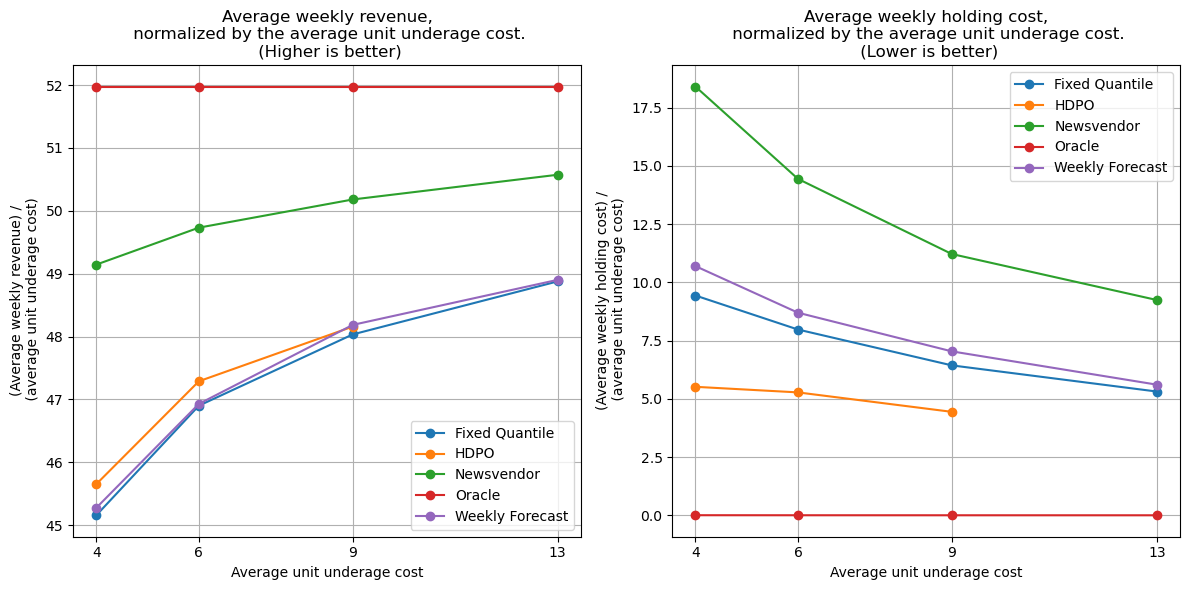

In [30]:
collect_data_and_plot(df, "test_on_dev", "one_store_real_data_lost_demand_fixed_vals", "store_underage_cost")

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    0.7                    6                -0.5             0          0.010    5.228738  5.237459   5.229138    0.718822
                    0.7                    6                -0.5             1          0.010    5.193958  5.200948   5.193782    0.037813
                    0.7                    6                -0.5            16          0.001    5.191816  5.199106   5.192705    0.017070
                    0.7                    6                -0.5            64          0.001    5.189119  5.198813   5.191818    0.000000
                    0.7                    6                 0.0             0          0.001    5.604022  5.613331   5.612740    1.504944
                    0.7                    6                 0.0             1          0.001    5.526807  5.540596   5.533923    0.079568
                    0.7    

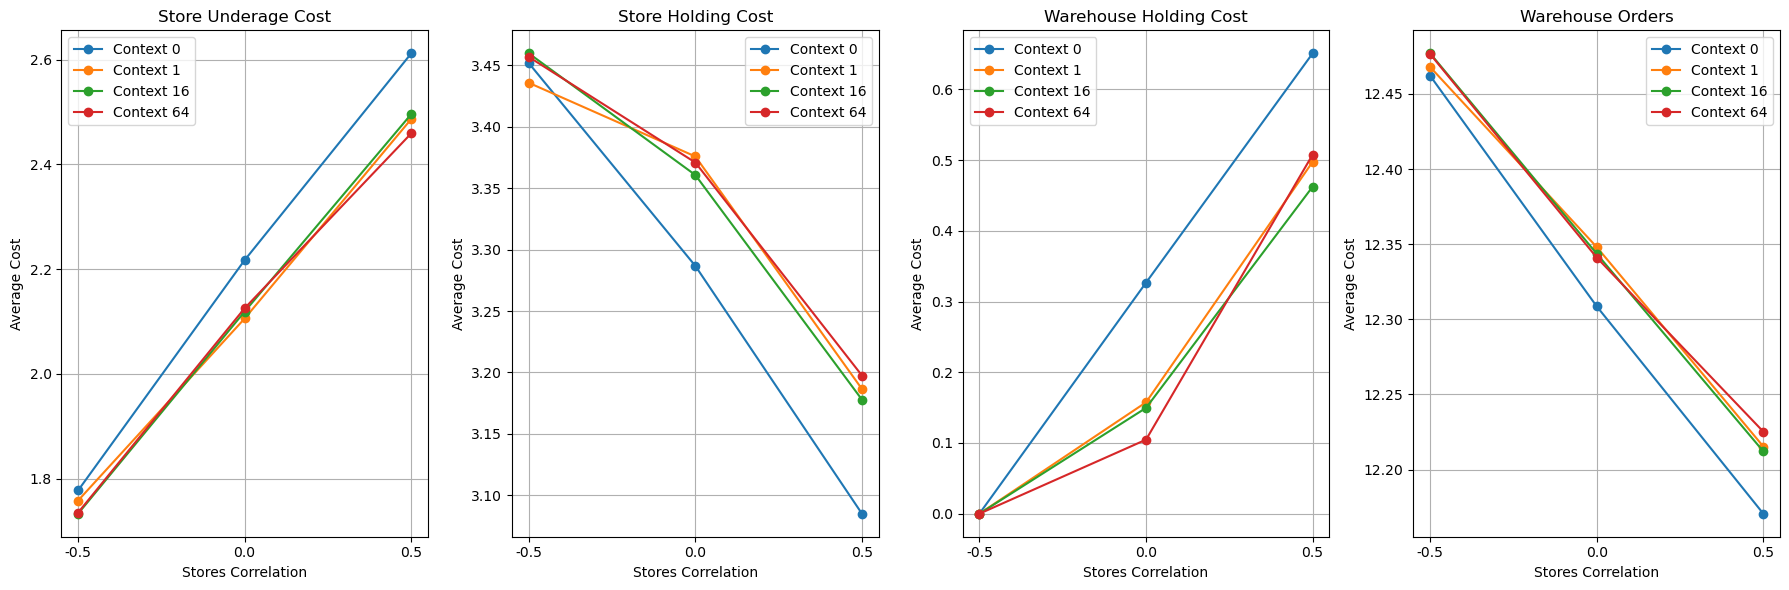

In [21]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'stores_correlation', {'warehouse_holding_cost': [0.7],'warehouse_lead_time': [6], 'stores_correlation': [-0.5, 0.0, 0.5]})

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    2.0                    6                -0.5             0          0.001    5.227845  5.237849   5.229256    0.712480
                    2.0                    6                -0.5             1          0.010    5.194059  5.201558   5.195194    0.056469
                    2.0                    6                -0.5            16          0.010    5.193197  5.199802   5.192262    0.000000
                    2.0                    6                -0.5            64          0.001    5.192500  5.200326   5.193359    0.021132
                    2.0                    6                 0.0             0          0.001    5.712041  5.707703   6.209399   12.103240
                    2.0                    6                 0.0             1          0.001    5.534035  5.546531   5.540761    0.031781
                    2.0    

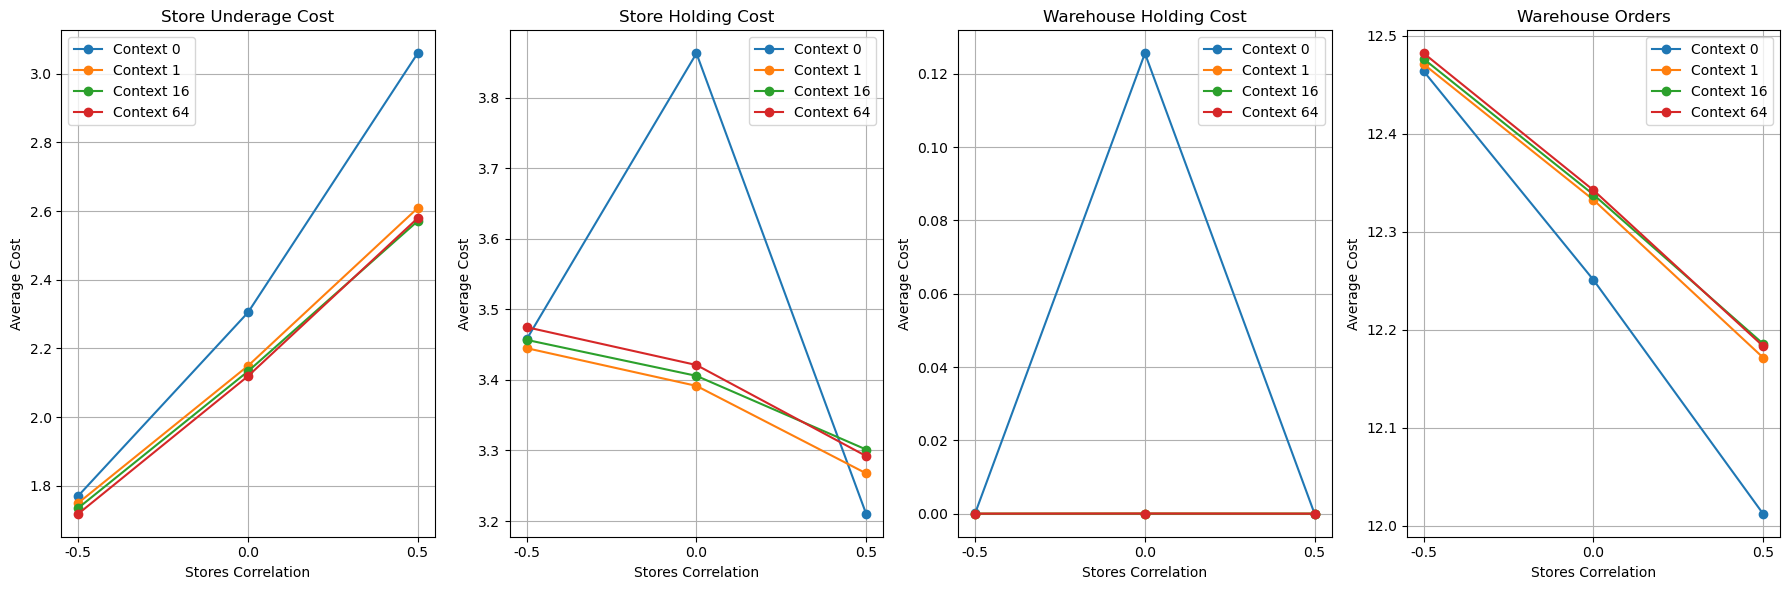

In [22]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'stores_correlation', {'warehouse_holding_cost': [2.0],'warehouse_lead_time': [6], 'stores_correlation': [-0.5, 0.0, 0.5]})

In [61]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/50'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/50'
}

shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
df = make_table_with_ctx_vanilla(ctx_paths, vanilla_paths, shared_conditions)
collect_data_and_plot(df, '# of stores')

 # of stores Architecture Class  warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
           3     Symmatry_Aware                     0.7                    2                 0.5             0         0.0100    5.694989  5.669734   5.666458    3.423637
           3     Symmatry_Aware                     0.7                    2                 0.5             1         0.0100    5.492721  5.486079   5.484402    0.100769
           3     Symmatry_Aware                     0.7                    2                 0.5            64         0.0010    5.481597  5.478923   5.478881    0.000000
           3            Vanilla                     0.7                    2                 0.5            -1         0.0001    5.507400  5.498954   5.498823    0.363985
          10     Symmatry_Aware                     0.7                    2                 0.5             0         0.0100    5.692854  5.6723

FileNotFoundError: [Errno 2] No such file or directory: 'results/primitive/10/0.7_2_0.5_[1].csv'

In [ ]:
# Print the DataFrame with better formatting for long paths
pd.set_option('display.max_colwidth', None)  # Set column width to unlimited
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.width', None)  # Set display width to unlimited

# Print the DataFrame
print(df.to_string())

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')


    # of stores Architecture Class  warehouse_holding_cost  warehouse_lead_time  stores_correlation  context  Learning Rate  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                   path
0             3                NaN                     0.7                    2                 0.5        0         0.0100    5.694989  5.669734   5.666458   /user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3/run_2024-08-01_20-29-16/run_40484_00000_0_context=0,learning_rate=0.0100,samples=1,stores_correlation=0.5000,warehouse_holding_cost=0.7000,warehouse_lead__2024-08-01_20-29-16
1             3                NaN                     0.7                    2                 0.5        1         0.0100    5.492721  5.486079   5.484402   /user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3/run_2024-08